In [54]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.cross_validation import LabelKFold, KFold
from IPython.display import display
from itertools import chain, combinations
from collections import Counter

import pandas as pd
import pickle as cp
import numpy as np
import seaborn as sns

pd.options.display.max_columns = 50
%matplotlib inline

## Model creation:
  * Load data
  * Extract/scale features
  * Split into test/train
  * Train Model
  * Evaluate performance

#### Settings

In [74]:
# Load the data into a single dataframe; votes + chosen census data
vote_file = '{}_clean_votes.csv'
# Codes: AGE, IPE, RHI, LND, CRM, POP, AGN
#census_codes = ['AGE', 'IPE', 'RHI', 'LND', 'CRM', 'POP', 'AGN']
#census_codes = ['AGE', 'IPE', 'RHI']
census_codes = []

In [75]:
# Load all of the voting data, filtering null vote counts or missing FIPS codes
def load_vote_data(filename, year, return_data=None):
    year = str(year)
    votes_data = pd.read_csv(filename.format(year)).drop(['Unnamed: 0'], axis=1)
    if return_data is None:
        return_data = votes_data[["FIPS", "State", "County"]].copy()
        return_data = return_data.drop(return_data[return_data['County'] == 'oglala lakota'].index[0])
        
    merge_data = votes_data[["FIPS"]].copy()    
    merge_data['Total_' + year] = votes_data['Total Votes']
    merge_data['Dem_' + year] = votes_data['Dem']
    merge_data['Rep_' + year] = votes_data['Rep']
    merge_data['Dfrac_' + year] = votes_data['Dem'] / votes_data['Total Votes']
    
    return_data = return_data.join(merge_data.set_index("FIPS"), on=["FIPS"], how="left")
    return return_data

def merge_census_data(model_data, codes):
    for code in census_codes:
        curr_data = pd.read_csv('proc_census_data/{}.csv'.format(code)).drop(['Unnamed: 0'], axis=1)
        model_data = model_data.join(curr_data.set_index("FIPS"), on=["FIPS"], how="left")
    
    return model_data

In [76]:
def column_ratio(df, numerators, denominators, name, to_remove=None, num_coeff=None, den_coeff=None):
    if num_coeff is None:
        num_coeff = np.ones(len(numerators))
    if den_coeff is None:
        den_coeff = np.ones(len(denominators))
    num = sum([df[col] * coeff for col, coeff in zip(numerators, num_coeff)])
    den = sum([df[col] * coeff for col, coeff in zip(denominators, den_coeff)])
    df[name] = num / den
    if to_remove is None:
        to_remove = list(set(numerators + denominators))
    df.drop(to_remove, axis=1, inplace=True)

In [77]:
md = load_vote_data(vote_file, 2012)
md = load_vote_data(vote_file, 2016, return_data=md)
md = merge_census_data(md, census_codes)

# Do some cross-data-type calculations
#column_ratio(md, ['Normalized Cropland - total'], ['Normalized Land area'],
#             'Agricultural Land Fraction', to_remove=['Normalized Cropland - total'])

#column_ratio(md, ['property crimes'], ['Resident population'], 'property crime rate', to_remove=['property crimes'])
column_ratio(md, ['Total_2016', 'Total_2012'], ['Total_2012'], 'TCF', to_remove=[], num_coeff=np.array([1, -1]))
column_ratio(md, ['Dem_2016', 'Dem_2012'], ['Dem_2012'], 'DCF', to_remove=[], num_coeff=np.array([1, -1]))
column_ratio(md, ['Rep_2016', 'Rep_2012'], ['Rep_2012'], 'RCF', to_remove=[], num_coeff=np.array([1, -1]))


#md['Log Votes'] = md['Total_2012'].apply(np.log)

display(md.head(100))

,FIPS,State,County,Total_2012,Dem_2012,Rep_2012,Dfrac_2012,Total_2016,Dem_2016,Rep_2016,Dfrac_2016,TCF,DCF,RCF
0,2000,AK,alaska,220596,91696,121234,0.415674,246588,93007,130415,0.377176,0.117826,0.014297,0.075730
1,1001,AL,autauga,23909,6354,17366,0.265758,24661,5908,18110,0.239569,0.031453,-0.070192,0.042842
2,1003,AL,baldwin,84988,18329,65772,0.215666,94090,18409,72780,0.195653,0.107097,0.004365,0.106550
3,1005,AL,barbour,11459,5873,5539,0.512523,10390,4848,5431,0.466603,-0.093289,-0.174527,-0.019498
4,1007,AL,bibb,8391,2200,6131,0.262186,8748,1874,6733,0.214220,0.042546,-0.148182,0.098190
5,1009,AL,blount,23980,2961,20741,0.123478,25384,2150,22808,0.084699,0.058549,-0.273894,0.099658
6,1011,AL,bullock,5318,4058,1250,0.763069,4701,3530,1139,0.750904,-0.116021,-0.130113,-0.088800
7,1013,AL,butler,9483,4367,5081,0.460508,8685,3716,4891,0.427864,-0.084151,-0.149073,-0.037394
8,1015,AL,calhoun,46240,15500,30272,0.335208,47376,13197,32803,0.278559,0.024567,-0.148581,0.083609
9,1017,AL,chambers,14562,6853,7596,0.470608,13778,5763,7803,0.418276,-0.053839,-0.159054,0.027251


### Data Analysis

In [78]:
md[(md['TCF'] > 0.1) & (md['RCF'] > 0.1)]

,FIPS,State,County,Total_2012,Dem_2012,Rep_2012,Dfrac_2012,Total_2016,Dem_2016,Rep_2016,Dfrac_2016,TCF,DCF,RCF
2,1003,AL,baldwin,84988,18329,65772,0.215666,94090,18409,72780,0.195653,0.107097,0.004365,0.106550
22,1043,AL,cullman,33178,4855,27930,0.146332,37278,3730,32734,0.100059,0.123576,-0.231720,0.172001
30,1059,AL,franklin,10859,3171,7567,0.292016,11955,2197,9466,0.183772,0.100930,-0.307159,0.250958
42,1083,AL,limestone,35406,9809,25263,0.277043,39400,9340,28824,0.237056,0.112806,-0.047813,0.140957
71,5007,AR,benton,77525,22144,53477,0.285637,94262,27894,60751,0.295920,0.215892,0.259664,0.136021
78,5021,AR,clay,5110,1738,3225,0.340117,5978,1999,3779,0.334393,0.169863,0.150173,0.171783
83,5031,AR,craighead,31207,10351,20044,0.331688,34968,10474,22798,0.299531,0.120518,0.011883,0.137398
103,5071,AR,johnson,8064,2785,5045,0.345362,8997,2421,6072,0.269090,0.115699,-0.130700,0.203568
110,5085,AR,lonoke,24083,5612,17863,0.233027,26766,5638,19902,0.210640,0.111406,0.004633,0.114147
138,5141,AR,van buren,6421,1826,4362,0.284379,7111,1547,5382,0.217550,0.107460,-0.152793,0.233838


### Model Training

In [114]:
def baseline_model(df, label_col, method='avg'):
    labels = df[label_col].values
    if method == 'avg':
        predictions = np.ones(len(labels)) * np.mean(labels)
    elif method == 'random':
        predictions = np.random.uniform(low=0, high=1, size=len(labels))
    rmse = np.sqrt(MSE(labels, predictions))
    print("Baseline model via '{}': {:.5f}".format(method, rmse))

In [158]:
def evaluate_model(df, label_col, feature_cols, sweight_col=None, fold_col=None, n_folds=10):
    # Create a numpy.array dataset
    if not feature_cols:
        return
    labels = df[label_col].values
    features = df[feature_cols].values
    
    sample_weights = np.ones(len(labels))
    if sweight_col:
        sample_weights = df[sweight_col].values
    
    # Identify how to fold: using a column (e.g. separate by state) or random sample
    if not fold_col:
        folds = KFold(len(labels), n_folds)
    else:
        folds = LabelKFold(df[fold_col].values, n_folds)
        
    pred_row = np.zeros(len(labels))
    results = []
    for train_idxs, test_idxs in folds:
        rfr = RandomForestRegressor()
        #rfr = rfr.fit(features[train_idxs], labels[train_idxs])
        rfr = rfr.fit(features[train_idxs], labels[train_idxs], sample_weights[train_idxs])
        predictions = rfr.predict(features[test_idxs])
        pred_row[test_idxs] = predictions
        rmse = np.sqrt(MSE(labels[test_idxs], predictions, sample_weights[test_idxs]))
        #rmse = np.sqrt(MSE(labels[test_idxs], predictions))
        results.append(rmse)
    df['predictions'] = pred_row
    feat_str = ', '.join([feature.replace('Normalized', '')[:8] for feature in feature_cols])
    print("Performance:  RMSE: {:.4f} +- {:.4f} for {}".format(np.mean(results), np.std(results), feat_str))
    return rfr

In [159]:
def random_sample(df, rfr, feature_cols, size=20):
    sample = np.random.choice(len(df), size=size)
    sorted_feat_names = [item[1] for item in sorted(zip(rfr.feature_importances_, feature_cols), reverse=True)]
    df = df[['County', 'Dfrac', 'predictions'] + sorted_feat_names]
    display(df.iloc[sample])

def powerset(iterable, min_ct=0, max_ct=None):
    if max_ct is None:
        max_ct = len(iterable)
    return list(map(list, chain.from_iterable(combinations(list(iterable),n) for n in range(min_ct, max_ct + 1))))

In [161]:
# Feature types | 0: base features, always used, 1: additional features, tested by adding one at a time, 2: unused features 
features = [(0, 'Asian'),
            (2, 'Black'),
            (0, 'Hispanic or Latino Origin'),
            (0, 'White'),
            (0, 'Voting Age Fraction'),
            (0, 'Normalized Median Income'),
            (2, 'Normalized Land area'),
            (0, 'Urban Fraction'),
            (2, 'Agricultural Land Fraction'),
            (2, 'Poverty Fraction'),
            (2, 'property crime rate'),
            (1, 'Total Votes'),
           ]
base_feature_cols = [feat[1] for feat in features if feat[0] == 0]
add_feature_cols = [feat[1] for feat in features if feat[0] == 1]

# Try to predict the fraction of democratic voters
label_col = 'Dfrac'

sweight_col = 'Total Votes'

# Fold by a column to try testing transfer predictability across values of that column (e.g. can a subset of states predict others)
fold_columns = [(0, 'State'),
                (0, 'FIPS'),
                (0, None)
                ]

fold_col = 'State'
fold_col = 'FIPS'
fold_col = None
#sample_cols = [2, 3, 4] + list(range(9, len(md.columns)))

baseline_model(md, label_col)
for add_feat_set in powerset(add_feature_cols, min_ct=0, max_ct=1):
    for fold_col in [fc[1] for fc in fold_columns if fc[0] == 0]:
        print("Folding by {}".format(fold_col))
        feature_cols = base_feature_cols + add_feat_set
        rfr = evaluate_model(md, label_col, feature_cols, sweight_col=sweight_col, fold_col=fold_col)
random_sample(md, rfr, feature_cols)

Baseline model via 'avg': 0.15325
Folding by State
Performance:  RMSE: 0.0923 +- 0.0136 for Asian, Hispanic, White, Voting A,  Median , Urban Fr
Folding by FIPS
Performance:  RMSE: 0.0845 +- 0.0040 for Asian, Hispanic, White, Voting A,  Median , Urban Fr
Folding by None
Performance:  RMSE: 0.0912 +- 0.0199 for Asian, Hispanic, White, Voting A,  Median , Urban Fr
Folding by State
Performance:  RMSE: 0.0895 +- 0.0155 for Asian, Hispanic, White, Voting A,  Median , Urban Fr, Total Vo
Folding by FIPS
Performance:  RMSE: 0.0815 +- 0.0038 for Asian, Hispanic, White, Voting A,  Median , Urban Fr, Total Vo
Folding by None
Performance:  RMSE: 0.0879 +- 0.0188 for Asian, Hispanic, White, Voting A,  Median , Urban Fr, Total Vo


,County,Dfrac,predictions,White,Total Votes,Asian,Hispanic or Latino Origin,Voting Age Fraction,Urban Fraction,Normalized Median Income
1671,howard,0.183908,0.241083,97.6,7.992269,0.2,1.7,0.754064,0.000000,0.999050
1248,livingston,0.325620,0.326828,96.7,11.567196,0.8,1.9,0.744500,0.531130,1.592649
2503,bandera,0.169000,0.350353,92.8,9.231417,0.3,16.7,0.803612,0.000000,1.061092
2799,augusta,0.221161,0.290849,93.4,10.509469,0.5,2.1,0.786373,0.196095,1.171602
1527,nodaway,0.267931,0.379220,94.5,9.152605,1.6,1.3,0.817587,0.496363,0.852579
1770,colfax,0.401821,0.270216,83.8,8.569975,0.4,47.2,0.793527,0.493745,0.903231
1459,barton,0.134019,0.157585,95.0,8.688117,0.2,1.9,0.740848,0.346154,0.830077
376,butts,0.270761,0.353482,69.9,9.156623,0.5,2.5,0.774889,0.186472,0.997957
1873,cabarrus,0.385134,0.336325,75.4,11.418637,2.0,9.4,0.725966,0.533360,1.231738
944,scott,0.107457,0.139231,90.1,7.677400,0.5,15.3,0.749595,0.746961,1.066555


In [120]:
for item in Counter(md['FIPS'].values).items():
    if item[1] > 1:
        print(item)

In [121]:
for pair in zip(feature_cols, rfr.feature_importances_):
    print (pair)

('Asian', 0.21651220953371811)
('Black', 0.043758358487825583)
('Hispanic or Latino Origin', 0.10110727279169562)
('White', 0.34551711168461091)
('Voting Age Fraction', 0.067872673354882881)
('Normalized Median Income', 0.055617047643412035)
('Normalized Land area', 0.038096741246168818)
('Urban Fraction', 0.083910472524655236)
('Agricultural Land Fraction', 0.047608112733030734)


In [96]:
sorted([1, 2])

[1, 2]

In [165]:
md['error'] = md['predictions'] - md['Dfrac']

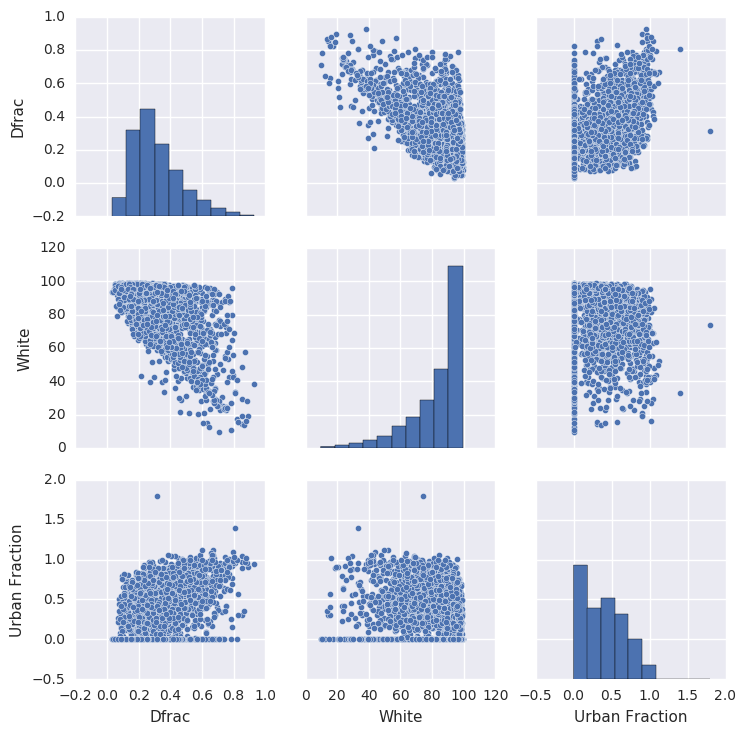

In [169]:
sns.set()
sns.pairplot(md[['Dfrac', 'White', 'Urban Fraction']])